Author: Hao Jiang

## Goal for this notebook
Due to previous work. We could see that Lasso and Tuned XGBoost looks cool.  
I want to find the best way to ensemble two model.  
No more basic model tuning here.

## Clean data
This part is based on a previous notebook. Many codes are commented.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
# train.head()

In [3]:
# combine the data and list the names of the columns
all_data = pd.concat((train.iloc[:,1:-1], test.iloc[:,1:-1]))
# check datasize
# all_data.shape

In [4]:
# Convert all object to categorical data
objColumns = all_data.dtypes[all_data.dtypes == 'object'].index

# There are several columns of categorical data represented as numeric. Convert them to categorical ones
for name in objColumns | pd.Index(['MSSubClass']):
    all_data[name] = all_data[name].astype("category")

In [5]:
# Convert all skewed numerical data and salePrice with log(1+p)
target = np.log1p(train['SalePrice'])

In [6]:
#  Try to convert skewed data, first check the columns
numColumns = all_data.dtypes[all_data.dtypes != "category"].index
skewed_feats = all_data[numColumns].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index

# print skewed_feats

In [7]:
# The skewed features seems find. Lets convert them
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Let's take a look at null data.For numerical data, GarageYrBlt, MasVnrArea and LotFrontage seems to have too many nulls.
Let's see if we could guess the right value from other data

In [8]:
for name in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    all_data.loc[all_data['GarageType'].isnull(),[name]] = 0

In [9]:
# Now lets handle LotFrontage
lotFeats = [name for name in all_data.columns if u'Lot' in name]
# all_data.loc[all_data['LotFrontage'].isnull(), lotFeats].head()

Let's take a look at the none null lot-related data and see if there's any correlation

Basically, null data distribution is similar to none-null ones. And LotFrontage seems to be somewhat linear correlated to LotArea. So let's just predict null LotFrontage with LotArea

In [10]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(all_data.loc[all_data['LotFrontage'].notnull(), ['LotArea']], all_data.loc[all_data['LotFrontage'].notnull(), ['LotFrontage']])
all_data.loc[all_data['LotFrontage'].isnull(), ['LotFrontage']] = reg.predict(all_data.loc[all_data['LotFrontage'].isnull(), ['LotArea']])

In [11]:
# For MasVnrArea it seems that when there is none Masonry veneer the area data apreas null
all_data.loc[all_data['MasVnrType'].isnull(), 'MasVnrArea'] = 0

In [12]:
# There're several pairs of feature that should be merged when one-hot encoded

# Deal with Exterior
for name in all_data["Exterior1st"].unique().dropna():
    all_data["Exterior-" + name] = 1 * ((all_data["Exterior1st"] == name) | (all_data["Exterior2nd"] == name))

# Deal with Condition
for name in all_data["Condition1"].unique().dropna():
    all_data["Condition-" + name] = 1 * ((all_data["Condition1"] == name) | (all_data["Condition2"] == name))

# Deal with BsmtFinType
for name in all_data["BsmtFinType1"].unique().dropna():
    all_data["BsmtFinType-" + name] = all_data["BsmtFinSF1"] * (all_data["BsmtFinType1"] == name) +  all_data["BsmtFinSF2"] * (all_data["BsmtFinType2"] == name)


In [13]:
all_data = all_data.drop(['Exterior1st','Exterior2nd'], axis=1)
all_data = all_data.drop(['Condition1','Condition2'], axis=1)
all_data = all_data.drop(['BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2'], axis=1)

In [14]:
# one-hot encode category data
all_data = pd.get_dummies(all_data)
# print all_data.shape

In [15]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

Here, to find the best balance. We should split the data.

In [16]:
from sklearn.model_selection import train_test_split
X_train = all_data[:train.shape[0]]
Y = target

X_train_train, X_train_test, Y_train, Y_test = train_test_split(all_data[:train.shape[0]],target, test_size = 0.3, random_state = 42)
X_test  = all_data[train.shape[0]:]

Now we have our two models here.

In [17]:
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb_model = XGBRegressor(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=1,
        gamma=0.01,
        subsample=0.6,
        colsample_bytree=0.86,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha = 1e-7,
        seed=100
)
lasso_model = Lasso(alpha = 0.0003)

Fit the model with train_train. And predict both train_train and train_test data.

In [18]:
# train the model
xgb_model.fit(X_train_train, Y_train)
lasso_model.fit(X_train_train, Y_train)

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
# Let's see how many variables the model picked
coef = pd.Series(lasso_model.coef_, index = X_train_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 143 variables and eliminated the other 128 variables


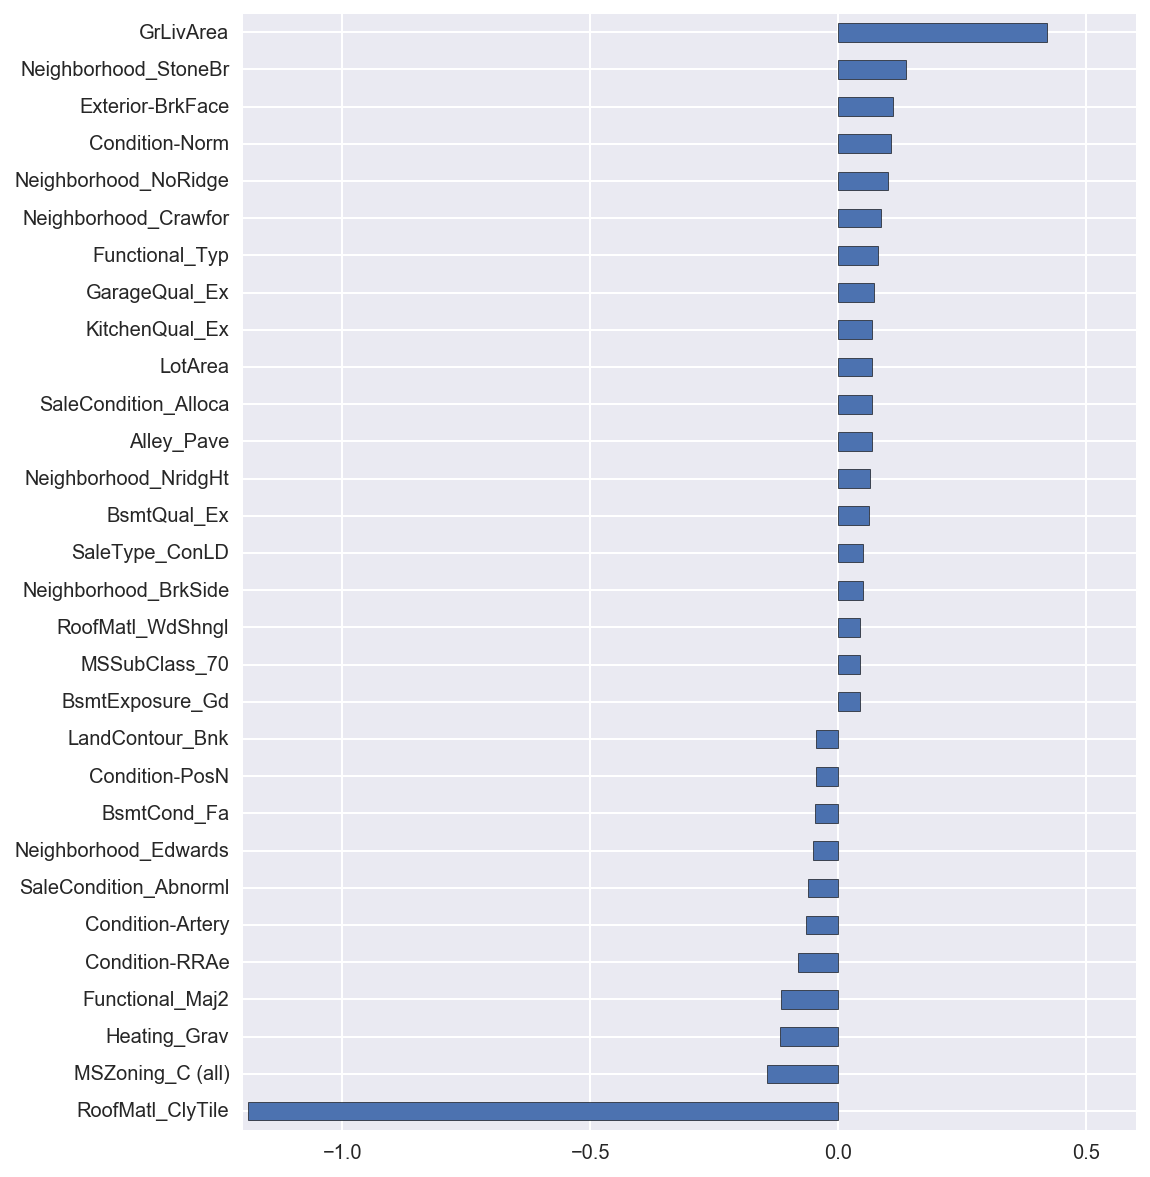

In [20]:
# Top 30 coef
top_lasso_coef = abs(coef).sort_values().tail(30).index

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef[top_lasso_coef].sort_values().plot(kind = "barh")

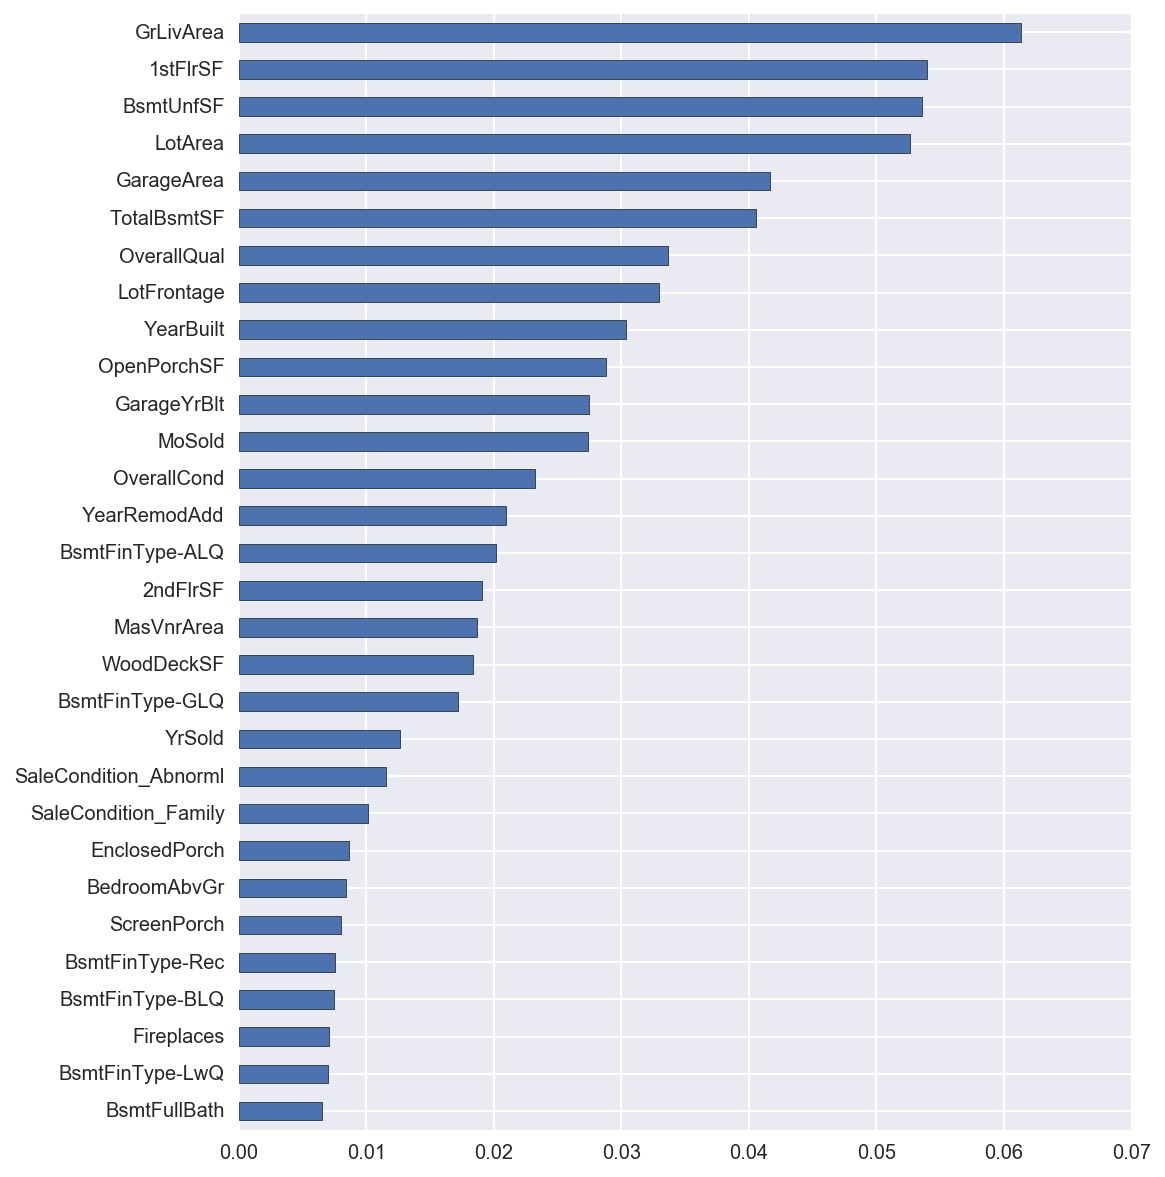

In [22]:
# What about xgb feature importance
xgb_feats_imp = pd.Series(xgb_model.feature_importances_, index = X_train_train.columns)
top_xgb_feats = xgb_feats_imp.sort_values().tail(30)
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
top_xgb_feats.plot(kind = "barh")

In [44]:
# predict
xgb_train_preds = np.expm1(xgb_model.predict(X_train_train))
lasso_train_preds = np.expm1(lasso_model.predict(X_train_train))

xgb_test_preds = np.expm1(xgb_model.predict(X_train_test))
lasso_test_preds = np.expm1(lasso_model.predict(X_train_test))

In [45]:
from sklearn.metrics import mean_squared_error

def plot_train_cv(start, end, step):
    train_train_rmse, train_test_rmse = [], []
    for i in (start + step * x for x in range(int((end - start) / step) + 1)):
        merged_pred = np.log1p(i * xgb_train_preds + (1.0 - i) * lasso_train_preds)
        train_train_rmse.append(np.sqrt(mean_squared_error(Y_train, merged_pred)))
        merged_pred = np.log1p(i * xgb_test_preds + (1.0 - i) * lasso_test_preds)
        train_test_rmse.append(np.sqrt(mean_squared_error(Y_test, merged_pred)))
    ensemble_rmse = pd.DataFrame(index = [start + step * x for x in range(int((end - start) / step) + 1)], data = {"TrainRMSE" : train_train_rmse, "TestRMSE" : train_test_rmse})
    ensemble_rmse.plot()
    print (ensemble_rmse['TestRMSE'].argmin(), ensemble_rmse['TestRMSE'].min())

(0.41999999999999998, 0.11798618808203233)


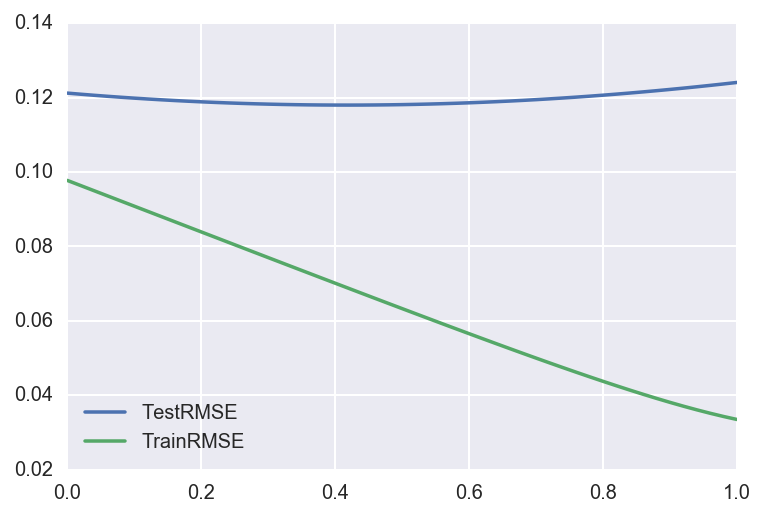

In [46]:
plot_train_cv(0, 1, 0.02)

(0.41800000000000004, 0.11798606045309762)


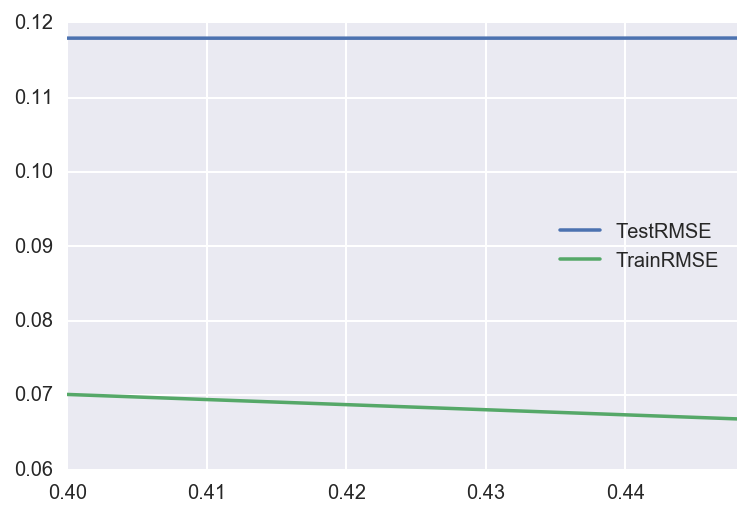

In [47]:
plot_train_cv(0.4, 0.45, 0.002)

So Xgb : Lasso = 0.418 : 0.582 seems the best.  
What about combine Ridge together?

In [48]:
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train_train, Y_train)
ridge_train_preds = np.expm1(ridge_model.predict(X_train_train))
ridge_test_preds = np.expm1(ridge_model.predict(X_train_test))

In [52]:
train_train_rmse, train_test_rmse = [], []
for i in range(11):
    new_train_rmse, new_test_rmse = [], []
    for j in range(11):
        if i + j <= 10:
            merged_pred = np.log1p(i / 10.0 * xgb_train_preds + j / 10.0 * lasso_train_preds + (10 - i - j) / 10.0 * ridge_train_preds)
            new_train_rmse.append(np.sqrt(mean_squared_error(Y_train, merged_pred)))
            merged_pred = np.log1p(i / 10.0 * xgb_test_preds + j / 10.0 * lasso_test_preds + (10 - i - j) / 10.0 * ridge_test_preds)
            new_test_rmse.append(np.sqrt(mean_squared_error(Y_test, merged_pred)))
        else:
            new_train_rmse.append(1)
            new_test_rmse.append(1)
    train_train_rmse.append(new_train_rmse)
    train_test_rmse.append(new_test_rmse)

print np.min(train_test_rmse)

0.117991574464


In [23]:
xgb_model.fit(X_train, Y)
lasso_model.fit(X_train, Y)

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
xgb_preds = np.expm1(xgb_model.predict(X_test))
lasso_preds = np.expm1(lasso_model.predict(X_test))
preds = 0.418 * xgb_preds + 0.582 * lasso_preds

solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("lasso_xgb.csv", index = False)